# Study of mobile application user behaviour

**Data Description**.

We have a dataset `logs_exp.csv`, where each record is a user action. The dataset has the following columns:

- `EventName` - the name of the event;
- `DeviceIDHash` - unique identifier of the user;
- `EventTimestamp` - time of the event;
- `ExpId` - experiment number: 246 and 247 are the control groups, and 248 is the experimental group.

**Research objective:** to study behavior of mobile application users

**Course of research:**

1. Obtaining general information about the data


2. Data preprocessing
    - columns names
    - data gaps
    - data type
    - duplicates
    

3. Data analysis - check the following metrics:
    - total amount events in the log file
    - total amount of users
    - average amount of events per user
    - define the time period
    

4. Examine the event funnel
   - what kind of events are there in the logs and how often they occur
   - how many users performed each of these events
   - event funnel
   - what percantage of users move on to the next step in the funnel


5. Analyse the results of the experiment
   - how many users are there in each experimental group
   - is there a statistical difference between the samples from groups 246 and 247
   - is there a statistical difference between the samples from groups 246 and 248
   - is there a statistical difference between the samples from groups 247 and 248.
   - is there a statistical difference between the combined samples of groups 246 and 247 and group 248.
   - draw conclusions about the success of the experiment

## Obtaining general information about the data

In [1]:
import pandas as pd
from scipy import stats as st
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from plotly import graph_objects as go
import math as mth
from pandas.plotting import register_matplotlib_converters
import warnings

In [2]:
try:
    shop = pd.read_csv('logs_exp.csv', sep='\t')
    display(shop)
except:
    print('Error')

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248
...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,1565212345,247
244122,MainScreenAppear,5849806612437486590,1565212439,246
244123,MainScreenAppear,5746969938801999050,1565212483,246
244124,MainScreenAppear,5746969938801999050,1565212498,246


## Data preprocessing

### Columns names

Let's lowercase and rename the column names for convenience.

In [3]:
shop.columns = shop.columns.str.lower()
shop = shop.rename(
    columns={
        'eventname': 'event_name',
        'deviceidhash': 'user_id',
        'eventtimestamp': 'timestamp',
        'expid': 'exp_id'
    }
)
shop

,event_name,user_id,timestamp,exp_id
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248
...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,1565212345,247
244122,MainScreenAppear,5849806612437486590,1565212439,246
244123,MainScreenAppear,5746969938801999050,1565212483,246
244124,MainScreenAppear,5746969938801999050,1565212498,246


### Data gaps

Let's check dataset for data gaps

In [4]:
shop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   event_name  244126 non-null  object
 1   user_id     244126 non-null  int64 
 2   timestamp   244126 non-null  int64 
 3   exp_id      244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


there are no data gaps in our dataset.

### Data types

The `time_stamp` column must be converted from `unix timestamp` format to `datetime` format. For this purpose we use the `pd.to_datetime` method.

In [5]:
shop['timestamp'] = pd.to_datetime(shop['timestamp'], unit='s')

shop.head()

,event_name,user_id,timestamp,exp_id
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248


I'll add a new column `date` and bring it to the required format.

In [6]:
shop['date'] = shop['timestamp'].dt.date
shop['date'] = pd.to_datetime(shop['date'])
shop.head()

,event_name,user_id,timestamp,exp_id,date
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25


### Intersections in groups

Let's check if there are users in the dataset who belong to more than one group.

In [7]:
shop.groupby('user_id').agg({'exp_id': 'nunique'}).query('exp_id > 1').count()

exp_id    0
dtype: int64

There are no such users in dataset.

### Duplicates

Let's check whether there are full duplicates in dataset.

In [8]:
print('Amount of full duplicates: {}, {}% from data'\
      .format(shop.duplicated().sum(),
              round(shop.duplicated().sum() / len(shop) * 100, 2)))

Amount of full duplicates: 413, 0.17% from data


There are full duplicates, but their number is insignificant. Let's remove them from the dataset.

In [9]:
shop = shop.drop_duplicates()
shop.duplicated().sum()

0

## Data analysis

### Amount of events in log

In [10]:
print(shop['event_name'].unique())
print(shop['event_name'].nunique())

['MainScreenAppear' 'PaymentScreenSuccessful' 'CartScreenAppear'
 'OffersScreenAppear' 'Tutorial']
5


In [11]:
len(shop['event_name'])

243713

There are 5 types of events:
- Main Screen Appear
- Payment Screen Successful
- Cart Screen Appear
- Offers Screen Appear
- Tutorial

which happened 244'126 times.

### Number of users in dataset

In [12]:
print('There are {} users in dataset'.format(shop['user_id'].nunique()))

There are 7551 users in dataset


### Average number of events per user

Let's first check if there are outliers in the data. Use the `describe()` method to see the distribution of values.

In [13]:
act_avg = shop.groupby('user_id').agg({'event_name': 'count'})
act_avg.describe()

,event_name
count,7551.000000
mean,32.275593
std,65.154219
min,1.000000
25%,9.000000
50%,20.000000
75%,37.000000
max,2307.000000


There are outliers in the data. The maximum number of events per user is 2308. The mean value is much higher than the median value. It's better to use the median to determine the average number of events per user.

In [14]:
act_avg.median()

event_name    20.0
dtype: float64

During the period under review, each user performed an average of 20 in-app actions.

### Period under review

In [15]:
print(min(shop['timestamp']))
print(max(shop['timestamp']))

2019-07-25 04:43:36
2019-08-07 21:15:17


Min date - 25 July 2019

Max date - 7 August 2019

Let's create a histogram for the `timestapm` column.

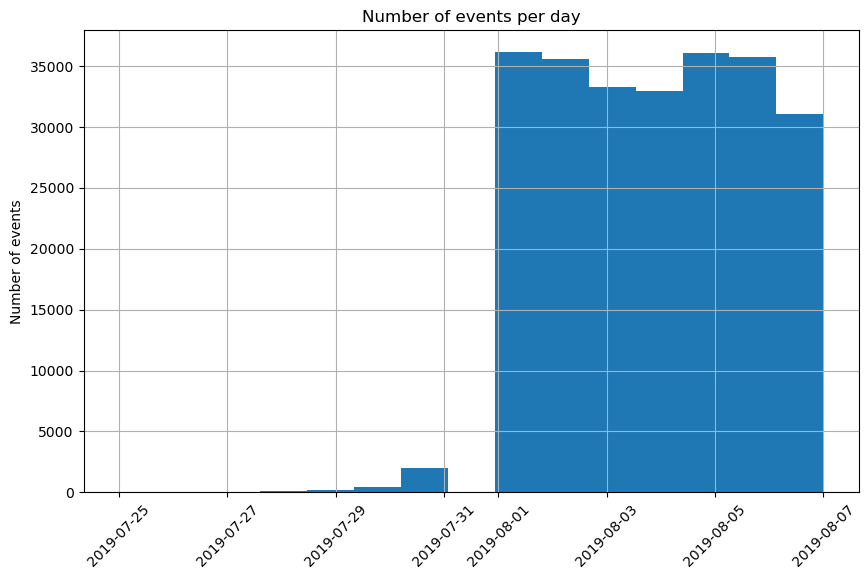

In [16]:
ax = shop['date'].hist(
    figsize=(10, 6),
    xrot = 45,
    bins=15
)

ax.set_title('Number of events per day')
ax.set_ylabel('Number of events');

The data from before 1 August looks incomplete. Let's take the data from the 1st of August onwards.

Create a new variable, where we'll keep the data for 1 week - from 1 to 7 August 2019.

''

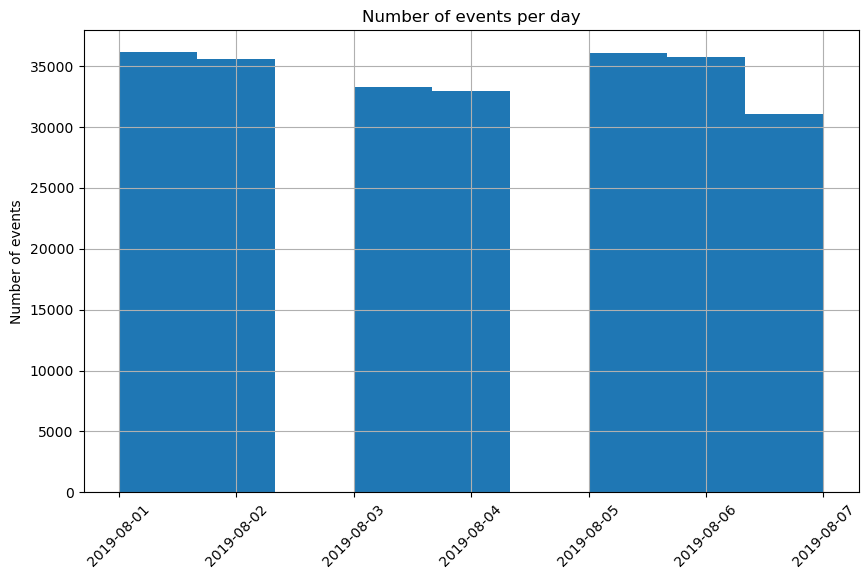

In [17]:
shop_cut = shop.query('date >= "2019-08-01"')
ax = shop_cut['date'].hist(
    figsize=(10, 6),
    xrot = 45,
    bins=9
)

ax.set_title('Number of events per day')
ax.set_ylabel('Number of events')
;

Let's check how many events and users were filtered out.

In [18]:
print('Number of events originally - {}, after filtration - {}. Deleted {} events, or {}% of data'\
      .format(len(shop),
              len(shop_cut),
              len(shop) - len(shop_cut),
              round(100 - len(shop_cut) / len(shop) * 100, 2)              
                                 ))

print()

print(
    'Number of users originally - {}, after filtration. Deleted {} users, or {}% of data'\
    .format(
        shop['user_id'].nunique(),
        shop_cut['user_id'].nunique(),
        shop['user_id'].nunique() - shop_cut['user_id'].nunique(),
        round(100 - shop_cut['user_id'].nunique() / shop['user_id'].nunique() * 100, 2)
))

Number of events originally - 243713, after filtration - 240887. Deleted 2826 events, or 1.16% of data

Number of users originally - 7551, after filtration. Deleted 7534 users, or 17% of data


The amount of deleted data is insignificant.

Let's make sure that there are users in each of the three experimental groups.

In [19]:
shop_cut.groupby('exp_id').agg({'user_id': 'nunique'}).reset_index()

,exp_id,user_id
0,246,2484
1,247,2513
2,248,2537


There are users in each of the three experimental groups, and they are fairly evenly distributed.

## Event funnel

Let's check what kind of events there are and how often they occur.

In [20]:
event_count = shop_cut['event_name'].value_counts().to_frame()
event_count = event_count.rename(columns={'event_name': 'event_count'})
event_count

,event_count
MainScreenAppear,117328
OffersScreenAppear,46333
CartScreenAppear,42303
PaymentScreenSuccessful,33918
Tutorial,1005


Let's count how many users committed to each of these events.

In [21]:
def get_event_count(event):
    users_count = shop_cut[shop_cut['event_name'] == event]['user_id'].nunique()
    return users_count

In [22]:
event_count = event_count.reset_index()
event_count['users_count'] = event_count['index'].apply(get_event_count)
event_count = event_count.sort_values(by='users_count', ascending=False)
event_count = event_count.set_index('index')
event_count.index.name = None
event_count['users %'] = round(
    event_count['users_count'] / shop_cut['user_id'].nunique() * 100
)

event_count

,event_count,users_count,users %
MainScreenAppear,117328,7419,98.0
OffersScreenAppear,46333,4593,61.0
CartScreenAppear,42303,3734,50.0
PaymentScreenSuccessful,33918,3539,47.0
Tutorial,1005,840,11.0


- the vast majority of users (98%) visited the main screen of the application
- 61% went to the product page
- 50% - half of them reached the shopping basket
- 47% successfully made a payment
- only a small proportion (11%) watched a tutorial

Let's attribute the following events to the funnel:
1. MainScreenAppear - users go to the main page
2. OffersScreenAppear - the user goes to the page with goods
2. CartScreenAppear - users go to the page with basket
3. PaymentScreenSuccessful - user pays for the order.

We decided to refer the Tutorial action to an optional one, which users may or may not perform at any stage of interaction with the mobile application. Let's not take it into account when calculating the funnel.

Let's create a separate variable for the event funnel and calculate what share of users goes to the next step of the funnel.

In [23]:
vortex = shop_cut.query('event_name != "Tutorial"')\
    .groupby('event_name')\
    .agg({'user_id': 'nunique'})\
    .sort_values(by='user_id', ascending=False)

vortex['conversion %'] = round(vortex['user_id'] / vortex['user_id'].shift(+1) * 100)
vortex = vortex.rename(columns={
    'user_id': 'user_count'
})
vortex.reset_index()

,event_name,user_count,conversion %
0,MainScreenAppear,7419,NaN
1,OffersScreenAppear,4593,62.0
2,CartScreenAppear,3734,81.0
3,PaymentScreenSuccessful,3539,95.0


Judging by the table, the most users are lost on the 2nd stage (OffersScreenAppear), when they go to the page with products. The best performance is on the transition from the basket to payment.

Let's visualise the event funnel.

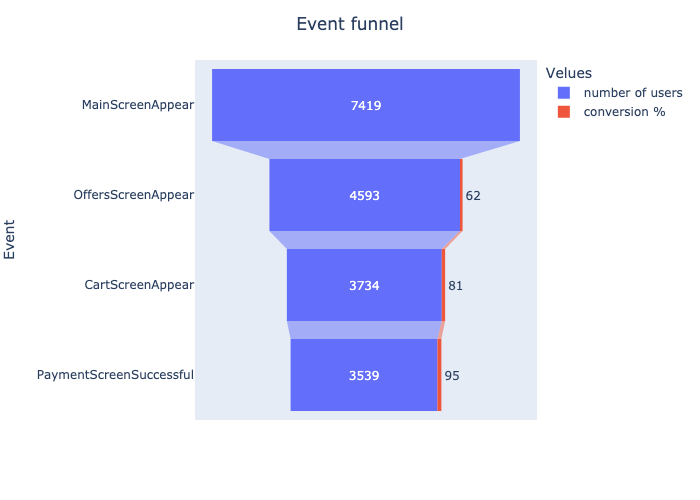

In [37]:
fig = px.funnel(
    vortex
)


fig.update_layout(
    title={
        'text': 'Event funnel',
        'x': 0.5,
        'xanchor': 'center'
    }
)

fig.update_layout(legend=dict(
    itemsizing='constant',
    itemclick='toggleothers',
    font=dict(size=12),
    title=dict(text='Velues')
))

newnames = {
    'user_count': 'number of users',
    'conversion %': 'conversion %'
}

fig.for_each_trace(lambda t: t.update(name = newnames[t.name]))


fig.update_yaxes(title_text='Event')

fig.show('png')

In [25]:
print('Percentage of users who make it from the first event to payment: {}%'
      .format(round(vortex['user_count'].iloc[3] / vortex['user_count'].iloc[0], 2) * 100)
     )

Percentage of users who make it from the first event to payment: 48.0%


Judging by the table, the most users are lost on the 2nd stage - OffersScreenAppear, when they go to the page with products. The best indicators are on the transition from the basket to payment.

## Analysing the results of the experiment

### Distribution of users between groups

Recall that we have 3 groups:
- 246 and 247 - control groups
- 248 - experimental

In [26]:
users_in_group = shop_cut.groupby('exp_id').agg({'user_id': 'nunique'})
users_in_group['perc'] = round(users_in_group['user_id'] / shop_cut['user_id'].nunique() * 100, 1)
users_in_group

,user_id,perc
exp_id,,
246,2484,33.0
247,2513,33.4
248,2537,33.7


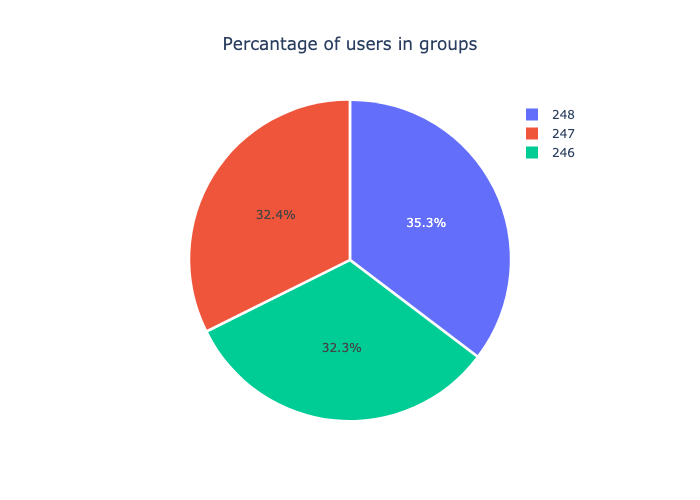

In [38]:
labels = shop_cut['exp_id']
values = shop_cut['user_id']

fig_groups = go.Figure(data=(go.Pie(labels=labels, values=values, pull=0.01)))

fig_groups.update_layout(
    title='Percantage of users in groups',
    title_x=0.5,
    legend=dict(x=0.8, y=1)
)

fig_groups.show('png')

The users are evenly distributed among the groups. There are about 2500 users in each group. Group 248 - the experimental group - is leading with a small gap.

### Preprating data for the test

In [28]:
# create a dataframe where we aggregate the data for the test
# calculate how many unique users performed a specific action in a given group
for_test = shop_cut\
    .query('event_name != "Tutorial"')\
    .pivot_table(
        index='exp_id',
        columns='event_name',
        values='user_id',
        aggfunc='nunique'
    ).reset_index()
    
# add a column to indicate the total number of users in each group
users_count = shop_cut.groupby('exp_id')['user_id'].nunique()
for_test['users_in_group'] = for_test['exp_id'].apply(lambda x: users_count.loc[x])
#for_test = for_test.set_index('exp_id')

# add a line with the sum of the data of groups 246 and 247 for the following A/B test
sum_row = pd.DataFrame({'exp_id': ['246_247'],
                        'CartScreenAppear': [for_test.loc[for_test['exp_id'].isin([246, 247]), \
                                                          'CartScreenAppear'].sum()],
                        'MainScreenAppear': [for_test.loc[for_test['exp_id'].isin([246, 247]),\
                                                          'MainScreenAppear'].sum()],
                        'OffersScreenAppear': [for_test.loc[for_test['exp_id'].isin([246, 247]), \
                                                            'OffersScreenAppear'].sum()],
                        'PaymentScreenSuccessful': [for_test.loc[for_test['exp_id'].isin([246, 247]),\
                                                                 'PaymentScreenSuccessful'].sum()],
                        'users_in_group': [for_test.loc[for_test['exp_id'].isin([246, 247]), \
                                                        'users_in_group'].sum()]
                       })

for_test = pd.concat([for_test, sum_row], ignore_index=True)

for_test

,exp_id,CartScreenAppear,MainScreenAppear,OffersScreenAppear,PaymentScreenSuccessful,users_in_group
0,246,1266,2450,1542,1200,2484
1,247,1238,2476,1520,1158,2513
2,248,1230,2493,1531,1181,2537
3,246_247,2504,4926,3062,2358,4997


The most popular action is to view the main screen - MainScreenAppear. Let's add a column that reflects what proportion of users performed this event.

In [29]:
for_test['main_screen %'] = round(for_test['MainScreenAppear'] / for_test['users_in_group'] * 100)
for_test

,exp_id,CartScreenAppear,MainScreenAppear,OffersScreenAppear,PaymentScreenSuccessful,users_in_group,main_screen %
0,246,1266,2450,1542,1200,2484,99.0
1,247,1238,2476,1520,1158,2513,99.0
2,248,1230,2493,1531,1181,2537,98.0
3,246_247,2504,4926,3062,2358,4997,99.0


In the control groups, 99% of users went to the home screen. In the experimental group a little less - 98%.

### Functions for the test

In [30]:
# create a function for the z-test
def return_z_test(successes, trials, alpha):
    # proportion of successes in group 1
    p1 = successes[0] / trials[0]
    
     # proportion of successes in group 2
    p2 = successes[1] / trials[1]
    
     # proportion of successes in combined group
    p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])
    
    # difference of proportions in datasets
    difference = p1 - p2
    
    # count statistics in st. deviations of the standard normal distribution
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))
    
    # set standard normal distribution (mean 0, standard deviation 1)
    distr = st.norm(0, 1)  
    
    # calculate p_value
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    
    print('p-значение: ', p_value)
    
    if p_value < alpha:
        print('We reject the null hypothesis: there is a significant difference between the shares')
        print('')
    else:
        print('We failed to disprove the null hypothesis')
        print('')

In [31]:
def groups_for_test (group1, group2, alpha):
    alpha_test = alpha
    count_users = ([
        for_test['users_in_group'][group1], for_test['users_in_group'][group2]
    ])
    
    count_main_screen_appear = ([
        for_test['MainScreenAppear'][group1], for_test['MainScreenAppear'][group2]
    ])
    
    count_offers_screen_appear = ([
        for_test['OffersScreenAppear'][group1], for_test['OffersScreenAppear'][group2]
    ])
    
    count_cart_screen_appear = ([
        for_test['CartScreenAppear'][group1], for_test['CartScreenAppear'][group2]
    ])
    
    count_payment_secces = ([
        for_test['PaymentScreenSuccessful'][group1], for_test['PaymentScreenSuccessful'][group2]
    ])
    
    print('Testing the hypothesis of equality of shares for an event main_screen_appear')
    return_z_test(count_main_screen_appear, count_users, alpha_test)
    
    print('Testing the hypothesis of equality of shares for an event offers_screen_appear')
    return_z_test(count_offers_screen_appear, count_users, alpha_test)
    
    print('Testing the hypothesis of equality of shares for an event cart_screen_appear')
    return_z_test(count_cart_screen_appear, count_users, alpha_test)
    
    print('Testing the hypothesis of equality of shares for an event payment_secces')
    return_z_test(count_payment_secces, count_users, alpha_test)

### A/A test - control groups

Let's test whether the statistical criteria find a difference between samples 246 and 247. To do this, we will test the hypothesis of equality of shares between the two groups by performing a z-test for each event in the funnel.

We choose a statistical significance level of 5%

ɑ = 0,05

- H0 - there is no significant difference between the shares
- H1 - there is a significant difference between the shares.

In [32]:
groups_for_test(0, 1, 0.05)

Testing the hypothesis of equality of shares for an event main_screen_appear
p-значение:  0.7570597232046099
We failed to disprove the null hypothesis

Testing the hypothesis of equality of shares for an event offers_screen_appear
p-значение:  0.2480954578522181
We failed to disprove the null hypothesis

Testing the hypothesis of equality of shares for an event cart_screen_appear
p-значение:  0.22883372237997213
We failed to disprove the null hypothesis

Testing the hypothesis of equality of shares for an event payment_secces
p-значение:  0.11456679313141849
We failed to disprove the null hypothesis



None of the four tests succeeded in disproving the null hypothesis. There is no reason to consider the fractions different. Two control groups are equal - we can be sure that the test is accurate.

### A1/B test

Let's find out if there is a difference between samples 246 and 248 (experimental group)

ɑ = 0,05

- H0 - there is no significant difference between the shares
- H1 - there is a significant difference between the shares.

In [33]:
groups_for_test(0, 2, 0.05)

Testing the hypothesis of equality of shares for an event main_screen_appear
p-значение:  0.2949721933554552
We failed to disprove the null hypothesis

Testing the hypothesis of equality of shares for an event offers_screen_appear
p-значение:  0.20836205402738917
We failed to disprove the null hypothesis

Testing the hypothesis of equality of shares for an event cart_screen_appear
p-значение:  0.07842923237520116
We failed to disprove the null hypothesis

Testing the hypothesis of equality of shares for an event payment_secces
p-значение:  0.2122553275697796
We failed to disprove the null hypothesis



None of the four tests disproves the null hypothesis.

### A2/B test

Let's find out if there is a difference between samples 247 and 248 (experimental group)

ɑ = 0,05

- H0 - there is no significant difference between the shares
- H1 - there is a significant difference between the shares.

In [34]:
groups_for_test(1, 2, 0.05)

Testing the hypothesis of equality of shares for an event main_screen_appear
p-значение:  0.4587053616621515
We failed to disprove the null hypothesis

Testing the hypothesis of equality of shares for an event offers_screen_appear
p-значение:  0.9197817830592261
We failed to disprove the null hypothesis

Testing the hypothesis of equality of shares for an event cart_screen_appear
p-значение:  0.5786197879539783
We failed to disprove the null hypothesis

Testing the hypothesis of equality of shares for an event payment_secces
p-значение:  0.7373415053803964
We failed to disprove the null hypothesis



None of the four tests disproves the null hypothesis. The p-value is very high for each of the tests.

### A1+A2/B-test

Let's find out if there is a difference between the summed samples from the control groups (246+247) and the experimental group 248.

In [35]:
groups_for_test(3, 2, 0.05)

Testing the hypothesis of equality of shares for an event main_screen_appear
p-значение:  0.29424526837179577
We failed to disprove the null hypothesis

Testing the hypothesis of equality of shares for an event offers_screen_appear
p-значение:  0.43425549655188256
We failed to disprove the null hypothesis

Testing the hypothesis of equality of shares for an event cart_screen_appear
p-значение:  0.18175875284404386
We failed to disprove the null hypothesis

Testing the hypothesis of equality of shares for an event payment_secces
p-значение:  0.6004294282308704
We failed to disprove the null hypothesis



None of the four tests disproves the null hypothesis. The p-value is very high for each of the tests.

## Correction

We ran a total of 16 tests (4 tests for 4 combinations of groups). Such a number of tests increases the group probability of the type I error. Let us find out what level of statistical significance should be chosen if we apply the Bonferroni correction.

To do this, we divide the accepted alpha value (0.05) by the number of conducted tests - 16.

In [36]:
ɑ1 = 0.05 / 16
ɑ1

0.003125

However, it makes no sense to run the tests again - we can see that the p-value does not fall below 0.078 in any of the tests. If we run the tests taking into account the correction, they will give the same result.

## Overall conclusion

We analysed the results of an A/A/B test conducted for an online retailer's mobile app. The purpose of the test was to find out whether changing the font throughout the app affects user behaviour and conversion rates.

The test was conducted on 3 groups:
- 246 - control
- 247 - control
- 248 - experimental

In the data preprocessing phase, we renamed the columns and brought the data with dates to the desired type, checked the data for omissions, and checked if there were users in the dataset who fell into multiple groups at once.

The dataset contains data from 25 July to 7 August 2019. However, we decided to keep data for only one week (1 to 7 August 2019) as the data from 25 July to 31 July does not appear to be complete. As a result of the filtering, we removed a negligible amount of data:
- 2828 events (1.16% of the data)
- 17 users (0.23% of the data)

We verified that there are users in each of the groups and that they are evenly distributed between the groups. There are about 2,500 users in each of the groups - 33% of the total.

We analysed the event funnel and found that users perform the following actions in the application:
- viewing the main screen - MainScreenAppear
- navigate to the page with products - OffersScreenAppear
- navigate to the cart page - CartScreenAppear
- paying for an order - PaymentScreenSuccessful
- viewing tutorial - Tutorial

We decided to classify the tutorial action as optional and not take it into account when calculating the event funnel.

We defined the event funnel and calculated what percentage of users move on to the next stage:
- MainScreenAppear - 98% of users
- OffersScreenAppear - 62% 
- CartScreenAppear - 81%
- PaymentScreenSuccessful - 95%

Most of all users are lost on the 2nd step - going to the page with products.

To analyse the results of the experiment, we conducted tests for 4 combinations of groups, for each step of the funnel:
- A/A-test
- A1/B-test
- A2/B-test
- A1+A2/B-test

A total of 16 tests were performed

**A/A-test** showed no differences between the groups. We made sure that the control groups were equal and the test was performed correctly.

**A1/B-test** - showed no differences between groups

**A2/B-test** - showed no differences between the groups.

**A1+A2/B-test** showed no differences between groups.

**It can be concluded that the font change did not affect user behaviour or conversion. The test can be completed.**